# FER Expressivity on BFS dataset using Norm-reference encoding

The goal is to train the NR mechanism using BFS's Louise and applied to the different expressivity level

## import

In [1]:
import os
import numpy as np
import tensorflow as tf

from utils.load_config import load_config
from utils.load_data import load_data
from datasets_utils.BVS_index import get_FER_ref_pos
from utils.extraction_model import load_extraction_model
from utils.PatternFeatureReduction import PatternFeatureSelection
from utils.patches import get_activity_from_patterns
from utils.patches import max_pool_patches_activity
from utils.Graph.facial_structure import get_face_structure
from utils.calculate_position import calculate_position
from models.NormBase import NormBase

%matplotlib inline
import matplotlib.pyplot as plt

np.random.seed(0)
np.set_printoptions(precision=3, suppress=True, linewidth=150)

## Set Parameters

In [2]:
# define configuration
config_path = 'NR_06a_FER_expressivity_on_BFS_m0001.json'

# load config
config = load_config(config_path, path='../../configs/norm_reference')

# create directory if non existant
save_path = os.path.join("../../models/saved", config["config_name"])
if not os.path.exists(save_path):
    os.mkdir(save_path)

## Load extraction pipeline

In [3]:
# load and define extraction model
v4_model = load_extraction_model(config, input_shape=tuple(config["input_shape"]))
v4_model = tf.keras.Model(inputs=v4_model.input, outputs=v4_model.get_layer(config['v4_layer']).output)
size_ft = tuple(np.shape(v4_model.output)[1:3])
print("[LOAD] size_ft", size_ft)
print("[LOAD] Model loaded")

1 Physical GPUs, 1 Logical GPUs
Metal device set to: Apple M1 Pro


2022-07-21 08:29:25.079079: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-21 08:29:25.079190: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


[LOAD] size_ft (56, 56)
[LOAD] Model loaded


## load training data

In [4]:
# load the training data to train the RBF templates: Louise and Merry neutral frame
data = load_data(config)
n_training = len(data[0])
print("[LOAD] Training Data loaded", np.shape(data[0]))
print("[LOAD] Labels Data loaded", np.shape(data[1]))
print()

/Users/michaelstettler/PycharmProjects/BVS/BVS/utils/load_data.py:431: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(sub_df, ignore_index=True)
100%|██████████| 3/3 [00:00<00:00, 145.13it/s]

[LOAD] Training Data loaded (3, 224, 224, 3)
[LOAD] Labels Data loaded (3,)



In [50]:
# plot the pre-processed images to see how the training data looks like
def plot_images(data, n_max_col=7, size_img=4):
    n_image = len(data[0])

    # compute n_row and n_col
    n_col = np.min([n_max_col, n_image])
    n_row = int(n_image / n_col)

    # declare figure
    plt.figure(figsize=(size_img * n_col, size_img * n_row))
    for i in range(n_row):
        for j in range(n_col):
            img_idx = i * n_col + j
            plt.subplot(n_row, n_col, img_idx + 1)
            img = np.array(data[0][img_idx] + 128) / 256
            rgb_img = img[..., ::-1]
            rgb_img[rgb_img > 1] = 1.0
            plt.imshow(rgb_img)

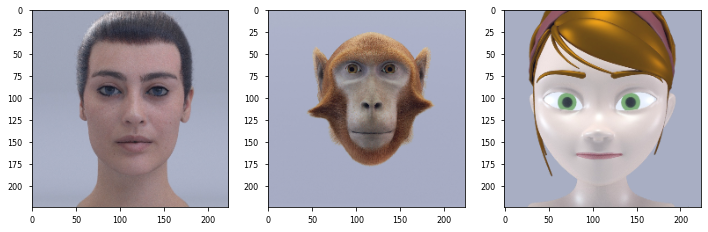

In [6]:
plot_images(data)

## Predict with extraction pipeline

In [7]:
def predict_v4(data):
    # predict v4 output
    preds = v4_model.predict(data[0], verbose=1)
    print("[predict_v4] shape prediction", np.shape(preds))
    print()

    # get feature maps that mimic a semantic selection pipeline
    # keep only highest IoU semantic score
    # FR predictions
    eyes_preds = preds[..., config['best_eyes_IoU_ft']]
    print("[predict_v4] shape eyes semantic feature selection", np.shape(eyes_preds))
    nose_preds = preds[..., config['best_nose_IoU_ft']]
    print("[predict_v4] shape nose semantic feature selection", np.shape(nose_preds))
    fr_preds = np.concatenate((eyes_preds, nose_preds), axis=3)
    print("[predict_v4] shape fr_preds", np.shape(fr_preds))
    print()

    # FER predictions
    eyebrow_preds = preds[..., config['best_eyebrow_IoU_ft']]
    print("[predict_v4] shape eyebrow semantic feature selection", np.shape(eyebrow_preds))
    lips_preds = preds[..., config['best_lips_IoU_ft']]
    print("[predict_v4] shape lips semantic feature selection", np.shape(lips_preds))
    fer_preds = np.concatenate((eyebrow_preds, lips_preds), axis=3)
    print("[predict_v4] shape fer_preds", np.shape(fer_preds))

    return fr_preds, fer_preds

In [8]:
fr_preds, fer_preds = predict_v4(data)

1/1 [==============================] - 0s 88ms/step
[predict_v4] shape prediction (3, 56, 56, 256)

[predict_v4] shape eyes semantic feature selection (3, 56, 56, 7)
[predict_v4] shape nose semantic feature selection (3, 56, 56, 61)
[predict_v4] shape fr_preds (3, 56, 56, 68)

[predict_v4] shape eyebrow semantic feature selection (3, 56, 56, 2)
[predict_v4] shape lips semantic feature selection (3, 56, 56, 16)
[predict_v4] shape fer_preds (3, 56, 56, 18)


2022-07-21 08:29:27.197309: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-07-21 08:29:27.240031: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


## Train and detect facial identity (Facial Recognition)

### Build RBF templates

In [9]:
def get_templates(preds, sigmas, rbfs, threshold=0.1, masks=None, zeros=None, verbose=False):
    # create FR templates
    templates = []
    rbf_templates = []
    patterns = []

    for i in range(len(preds)):
        config['rbf_sigma'] = config[sigmas[i]]
        rbf_template = np.array(config[rbfs[i]])

        mask = None
        zero = None
        if masks is not None:
            mask = np.array(config[masks[i]])
        if zeros is not None:
            zero = config[zeros[i]]
            print("loaded zero:")
            print(zero)

        pattern = PatternFeatureSelection(config, template=rbf_template, mask=mask, zeros=zero)

        # fit template
        neutral_preds = np.expand_dims(preds[i], axis=0)
        template_preds = np.repeat(np.expand_dims(neutral_preds, axis=0), len(rbf_template), axis=0)
        template = pattern.fit(template_preds)
        template[template < threshold] = 0

        templates.append(template[0])
        rbf_templates.append(rbf_template)
        patterns.append(pattern)

    templates = np.array(templates)

    if verbose:
        print("[RBF] shape templates", np.shape(templates))
        print("[RBF] Shape rbf_templates", np.shape(rbf_templates))

    return templates, rbf_templates, patterns

In [10]:
sigmas = ['louise_rbf_FR_sigma', 'monkey_rbf_FR_sigma', 'merry_rbf_FR_sigma']
rbfs = ['louise_rbf_FR_pos', 'monkey_rbf_FR_pos', 'merry_rbf_FR_pos']
fr_templates, rbf_fr_templates, fr_patterns = get_templates(fr_preds, sigmas, rbfs, threshold=0.2, verbose=True)

[RBF] shape templates (3, 56, 56, 3)
[RBF] Shape rbf_templates (3, 3, 2, 2)


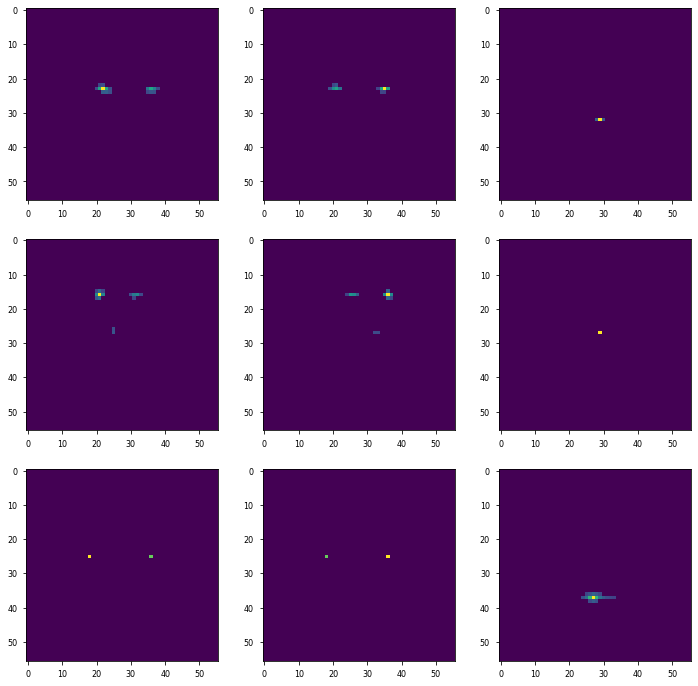

In [11]:
# show templates
n_templates = np.shape(fr_templates)[-1]

plt.figure(figsize=(n_templates * 4, n_training * 4))
for i in range(n_training):
    for j in range(n_templates):
        plt.subplot(n_training, n_templates, i * n_templates + j + 1)
        plt.imshow(fr_templates[i, ..., j])

## Compute LMKs types and pos using patches (Transformers trick) to get the reference face structure

In [12]:
def get_lmk(preds, patterns, rbf_templates, verbose=False, do_plot=False):
    # compute fr lmk activity
    lmks = []
    for i in range(np.shape(preds)[0]):
        lmk = get_activity_from_patterns(preds[i], patterns, rbf_templates, threshold_val=0.25, verbose=verbose, do_plot=do_plot)
        lmks.append(lmk)

        if verbose:
            for j in range(len(lmk)):
                print("[LMK] {}) {}".format(j, lmk[j]))
            print()

    return lmks

In [13]:
# compute activity from patterns
fr_lmks = get_lmk(fr_preds, fr_patterns, rbf_fr_templates, verbose=True)

max template pattern 0: [1. 1. 1.]
max template pattern 1: [0.    0.275 0.   ]
max template pattern 2: [0. 0. 0.]
[LMK] 0) {'type': 0, 'pos': [22.003262655858926, 22.999979621279522], 'max': 1.0}
[LMK] 1) {'type': 0, 'pos': [36.039804202291094, 22.999968607412693], 'max': 0.5933718608612403}
[LMK] 2) {'type': 0, 'pos': [22.51326403401181, 24.0], 'max': 0.30945918980134685}
[LMK] 3) {'type': 0, 'pos': [36.48491038242399, 24.0], 'max': 0.26870545363696435}
[LMK] 4) {'type': 1, 'pos': [20.93469826547703, 22.843460385313954], 'max': 0.5893314035700925}
[LMK] 5) {'type': 1, 'pos': [34.99158916358057, 22.999979295172622], 'max': 1.0}
[LMK] 6) {'type': 2, 'pos': [28.97691162181664, 32.0], 'max': 1.0}
[LMK] 7) {'type': 4, 'pos': [22.999837049795563, 21.999860328396196], 'max': 0.2749242154896316}

max template pattern 0: [0.254 0.255 0.   ]
max template pattern 1: [1. 1. 1.]
max template pattern 2: [0. 0. 0.]
[LMK] 0) {'type': 0, 'pos': [34.99992447012733, 16.99997482337578], 'max': 0.25419765

In [14]:
def get_max_pooled_lmks(activities_dict, verbose=False):
    activities_dict_max_pooled = []
    for i in range(len(activities_dict)):
        pooled_lmks = max_pool_patches_activity(activities_dict[i])
        activities_dict_max_pooled.append(pooled_lmks)

        if verbose:
            for j in range(len(pooled_lmks)):
                print("[LMK] {}) {}".format(j, pooled_lmks[j]))
            print()

    return activities_dict_max_pooled

In [15]:
# max-ppol the activity
fr_lmks_pooled = get_max_pooled_lmks(fr_lmks, verbose=True)

[LMK] 0) {'type': 0, 'pos': [22.003262655858926, 22.999979621279522], 'max': 1.0}
[LMK] 1) {'type': 1, 'pos': [34.99158916358057, 22.999979295172622], 'max': 1.0}
[LMK] 2) {'type': 2, 'pos': [28.97691162181664, 32.0], 'max': 1.0}

[LMK] 0) {'type': 3, 'pos': [20.885799588867044, 16.246051447119303], 'max': 1.0}
[LMK] 1) {'type': 4, 'pos': [35.997630603567885, 16.142617837993775], 'max': 1.0}
[LMK] 2) {'type': 5, 'pos': [28.9999680002048, 26.999980800122877], 'max': 1.0}

[LMK] 0) {'type': 6, 'pos': [17.999987200081918, 24.99999360004096], 'max': 1.0}
[LMK] 1) {'type': 7, 'pos': [35.999974400163836, 24.99999360004096], 'max': 1.0}
[LMK] 2) {'type': 8, 'pos': [27.204542116150083, 36.87356631391144], 'max': 1.0}



In [16]:
ref_struct = fr_lmks_pooled
print("Ref struct saved!")

Ref struct saved!


## Construct Facial Recognition (FR) pipeline

Compute facial attributes (type, position, size) using the landmarks types and positions. The landmarks are computed from the activity maps using the patches and a graph is applied to get the facial strucutre

In [17]:
def get_type(activity_dict, verbose=False):
    """
    max pool the types of the dictionary to get the face type
    """
    types = [0, 0, 0]  # hum_type, monk_type, cart_type

    for i in activity_dict:
        if verbose:
            print(activity_dict[i])
        dict = activity_dict[i]

        # count types
        if dict['type'] in [0, 1, 2]:
            types[0] += 1 * activity_dict[i]["max"]
        elif dict['type'] in [3, 4, 5]:
            types[1] += 1 * activity_dict[i]["max"]
        elif dict['type'] in [6, 7, 8]:
            types[2] += 1 * activity_dict[i]["max"]

    if verbose:
        print("types:", types)

    bfs_type = np.argmax(types)

    return bfs_type

In [18]:
def get_face_pos(activity_dict, verbose=False):
    positions = []

    for i in activity_dict:
        dict = activity_dict[i]

        # get positions of types
        if dict['type'] in [0, 3, 6]:
            right_eye_pos = dict['pos']
        elif dict['type'] in [1, 4, 7]:
            left_eye_pos = dict['pos']
        elif dict['type'] in [2, 5, 8]:
            nose_pos = dict['pos']

        positions.append(dict['pos'])

        if verbose:
            print("positions")
            print(positions)

    mean_pos = np.mean(positions, axis=0)
    width = np.abs(left_eye_pos[0] - right_eye_pos[0])
    height = nose_pos[1] - np.amin([left_eye_pos[1], right_eye_pos[1]])

    return mean_pos, [width, height]

In [19]:
def predict_face_attributes(preds, patterns, rbf_templates, ref_struct, threshold=0.2, verbose=False):
    attributes = {}
    for i in range(len(preds)):
        # compute landmarks
        activity_dict = get_activity_from_patterns(preds[i], patterns, rbf_templates, threshold_val=threshold)
        activities_dict_max_pooled = max_pool_patches_activity(activity_dict)

        # apply graph to get the structure
        bfs_type = get_type(activity_dict)
        face_dict = get_face_structure(activities_dict_max_pooled, ref_struct[bfs_type])
        pos, size = get_face_pos(face_dict)

        # compute scale ratio
        ref_dist_eye = ref_struct[bfs_type][1]["pos"][0] - ref_struct[bfs_type][0]["pos"][0]
        scale = size[0] / ref_dist_eye

        if verbose:
            print("types", bfs_type)
            print("pos:", pos)
            print("size:", size)
            print("scale:", scale)
            print()

        attributes[i] = {'type': bfs_type, 'pos': pos, 'size': size, 'scale':scale}
    return attributes

In [20]:
fr_attributes = predict_face_attributes(fr_preds, fr_patterns, rbf_fr_templates, ref_struct, verbose=True)

types 0
pos: [28.523 25.947]
size: [13.054688536415402, 9.159765263500642]
scale: 1.0051093594432126

types 1
pos: [28.656 19.82 ]
size: [15.19589852828748, 10.785455353207723]
scale: 1.0055630263139428

[INFER_NOSE] TODO infer nose better!, so far simply return the prior since it is a the center of both eyes as the dataset is super simple...
types 2
pos: [27.065 28.97 ]
size: [17.999987200081918, 11.910444059539905]
scale: 1.0



In [21]:
def draw_lmks_on_images(data, lmks):
    # display FR lmks on training img
    img_to_ft_ratio = 224 / 56

    n_images = len(data[0])
    plt.figure(figsize=(4 * n_images, 4))
    plt.suptitle("Landmarks for Facial Recognition on Neutral Pose")
    for i in range(n_images):
        plt.subplot(1, n_images, i + 1)
        img = np.array(data[0][i])
        img = img[..., ::-1]
        img = (np.array(img) + 127.5) / 256

        lmk = lmks[i]
        n_lmk = len(lmk)
        for j in range(n_lmk):
            lmk_pos = np.array(lmk[j]['pos']) * img_to_ft_ratio
            pos_x = int(round(lmk_pos[0]))
            pos_y = int(round(lmk_pos[1]))
            img[(pos_y-1):(pos_y+1), (pos_x-1):(pos_x+1)] = [1, 0, 0]

        plt.imshow(img)
        # plt.imsave("test_0.jpg", img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


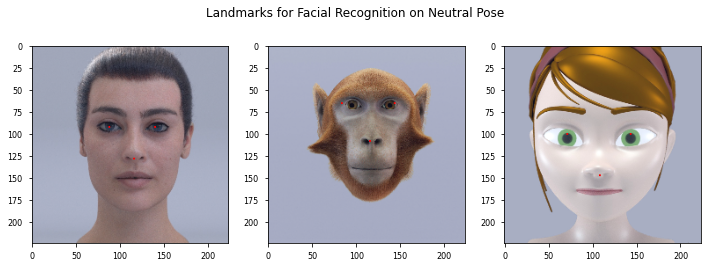

In [22]:
draw_lmks_on_images(data, fr_lmks_pooled)

## Construct the Facial Expression Recognition (FER) pipeline

In [23]:
ref_sigmas = ['louise_rbf_FER_sigma', 'monkey_rbf_FER_sigma', 'merry_rbf_FER_sigma']
ref_rbfs = ['louise_rbf_FER_pos', 'monkey_rbf_FER_pos', 'merry_rbf_FER_pos']
ref_rbfs_mask = ['louise_rbf_FER_mask', 'monkey_rbf_FER_mask', 'merry_rbf_FER_mask']
ref_rbfs_zeros = ['louise_rbf_FER_zeros', 'monkey_rbf_FER_zeros', 'merry_rbf_FER_zeros']

fer_templates,  rbf_fer_templates, fer_patterns = get_templates(fer_preds,
                                                                ref_sigmas,
                                                                ref_rbfs,
                                                                threshold=0.1,
                                                                masks=ref_rbfs_mask,
                                                                zeros=ref_rbfs_zeros,
                                                                verbose=True)

loaded zero:
{'0': {'idx': 4, 'pos': [[40, 47], [15, 22]]}, '1': {'idx': 6, 'pos': [[40, 47], [38, 41]]}}
loaded zero:
{'0': {'idx': 4, 'pos': [[31, 34], [25, 29]]}, '1': {'idx': 4, 'pos': [[42, 43], [20, 23]]}}
loaded zero:
{'0': {'idx': 6, 'pos': [[43, 47], [34, 41]]}}
[RBF] shape templates (3, 56, 56, 10)
[RBF] Shape rbf_templates (3, 10, 2, 2)


shape fer_templates (3, 56, 56, 10)


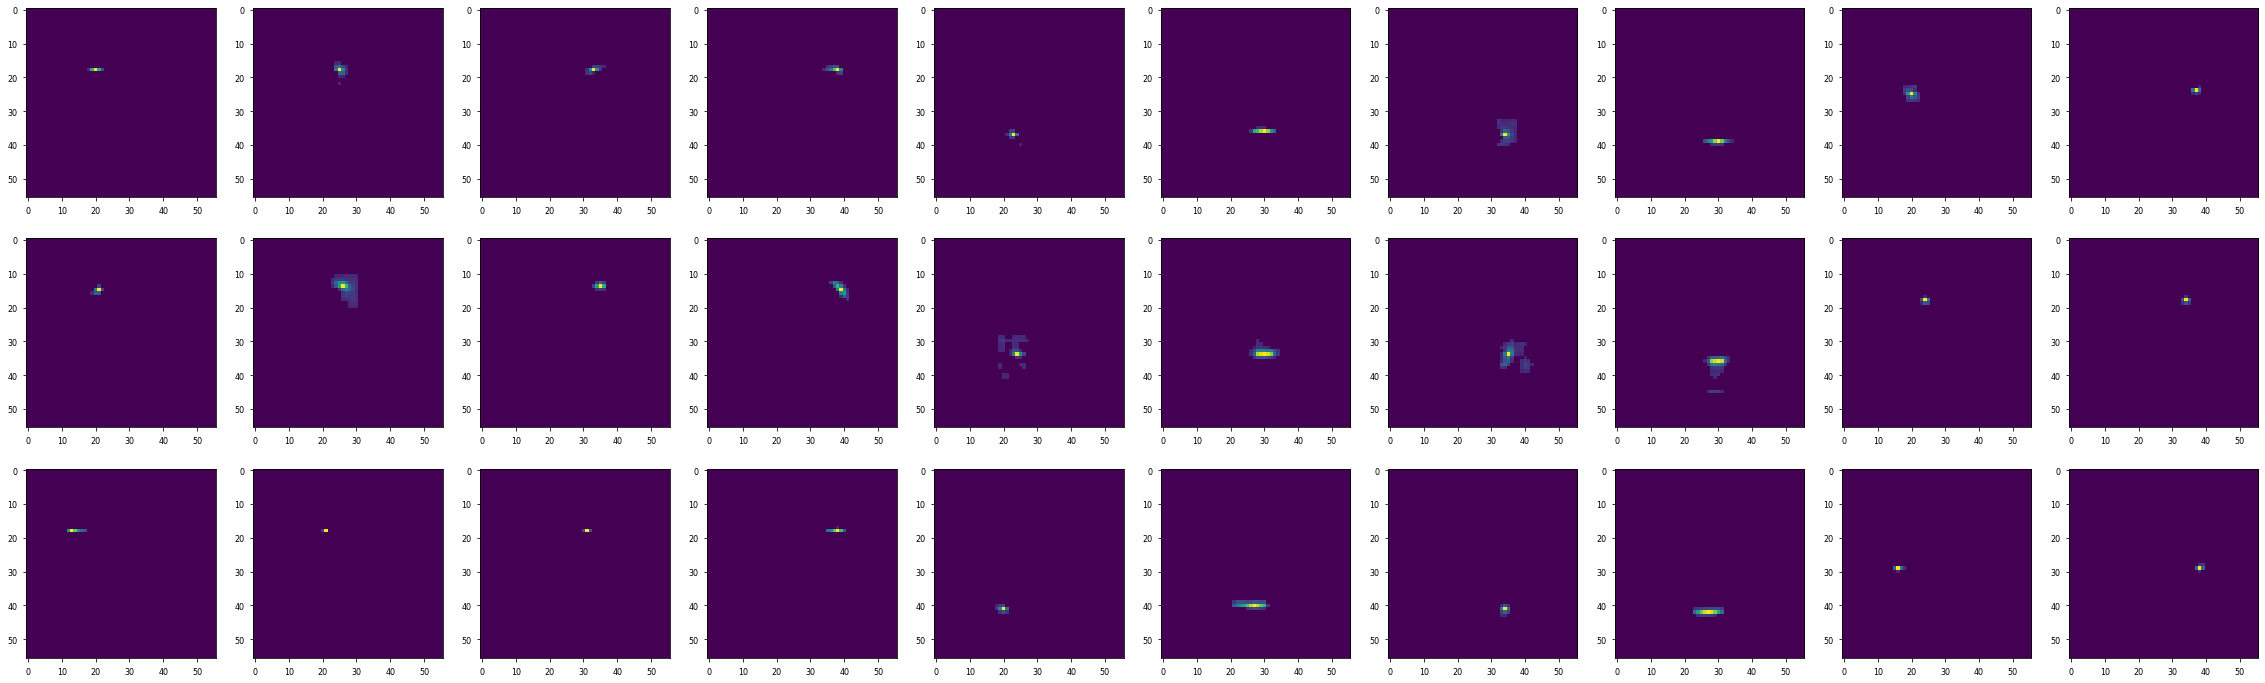

In [24]:
# show fer templates
print("shape fer_templates", np.shape(fer_templates))
n_templates = np.shape(fer_templates)[-1]

plt.figure(figsize=(n_templates * 4, n_training * 4))
for i in range(n_training):
    for j in range(n_templates):
        plt.subplot(n_training, n_templates, i * n_templates + j + 1)
        plt.imshow(fer_templates[i, ..., j])

In [25]:
def get_FER_lmks_pos(preds, face_types, patterns, rbf_templates, face_scales):
    fer_lmks_pos = []
    # get positions of the activity map
    for i in range(len(preds)):
        # get activity index per head type (identity)
        face_type = face_types[i]

        # expand dims to fit the transform requirements
        template_preds = np.expand_dims(preds[i], axis=0)
        template_preds = np.repeat(np.expand_dims(template_preds, axis=0), len(rbf_templates[face_type]), axis=0)

        # get template activity
        template = patterns[face_type].transform(template_preds, face_x_scales=[face_scales[i]], verbose=False)
        template[template < 0.1] = 0

        # compute position
        pos = calculate_position(template, mode="weighted average", return_mode="xy float flat")
        fer_lmks_pos.append(pos)

    return np.squeeze(fer_lmks_pos)

In [26]:
def transform_attributes_to_pos_and_scale(attributes):
    types = []
    scales = []
    for attr in attributes:
        types.append(attributes[attr]['type'])
        scales.append(np.round(attributes[attr]['scale'], decimals=1))
    return types, scales

In [27]:
fr_types, fr_scales = transform_attributes_to_pos_and_scale(fr_attributes)
fer_lmks_pos = get_FER_lmks_pos(fer_preds, fr_types, fer_patterns, rbf_fer_templates, fr_scales)
print("shape fer_lmks_pos", np.shape(fer_lmks_pos))
fer_type_ref = fer_lmks_pos

shape fer_lmks_pos (3, 20)


In [28]:
def draw_fer_lmks_on_images(data, lmk_pos, flat=True):
    # plot landmarks on images
    img_to_ft_ratio = 224 / 56
    if flat:
        # reshape fer_lmks
        lmk_pos = np.reshape(lmk_pos, (len(lmk_pos), -1, 2))

    n_images = len(data[0])
    plt.figure(figsize=(4 * n_images, 4))
    plt.suptitle("Landmarks for Facial Recognition on Neutral Pose")
    for i in range(n_images):
        plt.subplot(1, n_images, i + 1)
        img = np.array(data[0][i])
        img = img[..., ::-1]
        img = (np.array(img) + 127.5) / 256

        lmk = lmk_pos[i]
        n_lmk = len(lmk)
        for j in range(n_lmk):
            pos = lmk[j] * img_to_ft_ratio
            pos_x = int(round(pos[1]))
            pos_y = int(round(pos[0]))
            img[(pos_y-1):(pos_y+1), (pos_x-1):(pos_x+1)] = [1, 0, 0]

        plt.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


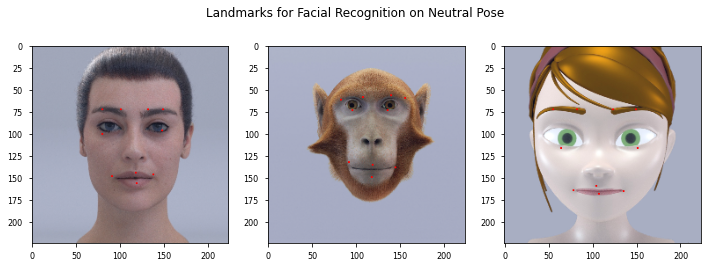

In [29]:
draw_fer_lmks_on_images(data, fer_lmks_pos)

# Train Norm-referenced encoding

### get facial expression training set on Louise

In [30]:
# load the training data to train ref and tuning vectors: Louise all expressions
config['train_avatar'] = 'Louise'
config['train_expression'] = ['full']
train_expression_data = load_data(config)
n_train_expression = len(train_expression_data[0])
print("[LOAD] train_expression_data loaded", np.shape(train_expression_data[0]))
print("[LOAD] n_train_expression", n_train_expression)

/Users/michaelstettler/PycharmProjects/BVS/BVS/utils/load_data.py:431: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(sub_df, ignore_index=True)
100%|██████████| 7/7 [00:00<00:00, 172.01it/s]

[LOAD] train_expression_data loaded (7, 224, 224, 3)
[LOAD] n_train_expression 7


In [31]:
def predict_fer_lmk_pos(data, ref_struct, threshold=0.2, get_types_and_scale=False):
    # get preds from VGG
    fr_preds, fer_preds = predict_v4(data)

    # compute FR pipeline
    fr_attributes = predict_face_attributes(fr_preds, fr_patterns, rbf_fr_templates, ref_struct, threshold=threshold)
    print("FR pipeline finished")

    # get face types and scales
    fr_types, fr_scales = transform_attributes_to_pos_and_scale(fr_attributes)
    print("face types and scales retrieved!")

    # compute FER pipeline
    fer_lmks_pos = get_FER_lmks_pos(fer_preds, fr_types, fer_patterns, rbf_fer_templates, fr_scales)
    print("FER pipeline finished!")

    if get_types_and_scale:
        return fer_lmks_pos, fr_types, fr_scales
    else:
        return fer_lmks_pos

In [32]:
fer_pos = predict_fer_lmk_pos(train_expression_data, ref_struct)
print("fer_pos:", np.shape(fer_pos))

1/1 [==============================] - 0s 37ms/step
[predict_v4] shape prediction (7, 56, 56, 256)

[predict_v4] shape eyes semantic feature selection (7, 56, 56, 7)
[predict_v4] shape nose semantic feature selection (7, 56, 56, 61)
[predict_v4] shape fr_preds (7, 56, 56, 68)

[predict_v4] shape eyebrow semantic feature selection (7, 56, 56, 2)
[predict_v4] shape lips semantic feature selection (7, 56, 56, 16)
[predict_v4] shape fer_preds (7, 56, 56, 18)
[INFER_NOSE] TODO infer nose better!, so far simply return the prior since it is a the center of both eyes as the dataset is super simple...
[INFER_NOSE] TODO infer nose better!, so far simply return the prior since it is a the center of both eyes as the dataset is super simple...
[INFER_NOSE] TODO infer nose better!, so far simply return the prior since it is a the center of both eyes as the dataset is super simple...
FR pipeline finished
face types and scales retrieved!
FER pipeline finished!
fer_pos: (7, 20)


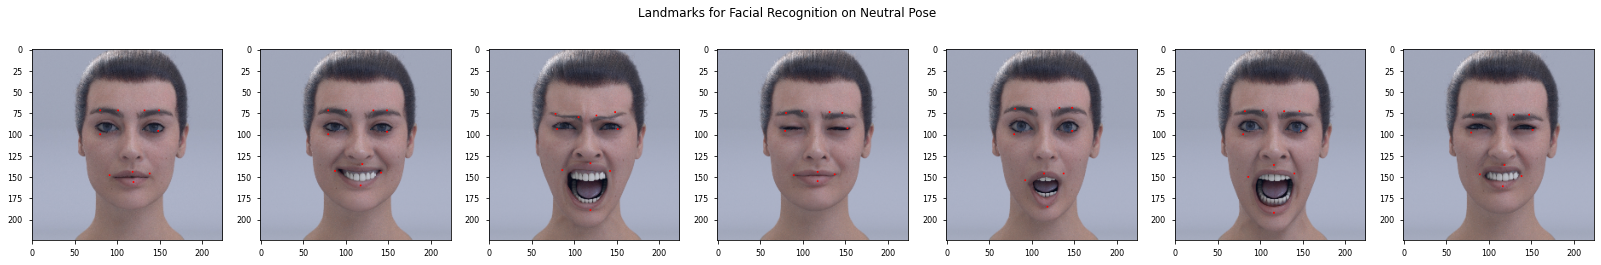

In [33]:
#plot landmarks on images
draw_fer_lmks_on_images(train_expression_data, fer_pos)

### Train Norm-reference Model

In [34]:
def train_NR_model(data, fer_pos, verbose=False):
    # declare a model to access its functions and train it
    nre_model = NormBase(config, tuple(config['input_shape']))
    nre_model.n_features = np.shape(fer_pos)[-1]
    nre_model.r = np.zeros(nre_model.n_features)  # need to reset the size since initial set it to the size of VGG

    # train manually ref vector
    nre_model._fit_reference([fer_pos, data[1]], config['batch_size'])

    # train manually tuning vector
    nre_model.t = np.zeros((nre_model.n_category, nre_model.n_features))
    nre_model.t_mean = np.zeros((nre_model.n_category, nre_model.n_features))
    nre_model._fit_tuning([fer_pos, data[1]], config['batch_size'])
    # get it nre_model
    it_train = nre_model._get_it_resp(fer_pos)

    if verbose:
        print("[NR TRAIN] shape fer_pos", np.shape(fer_pos))
        print("[NR TRAIN] model.r", np.shape(nre_model.r))
        print("[NR TRAIN] shape it_train", np.shape(it_train))

    return nre_model, it_train

In [35]:
nre_model, nre_pred = train_NR_model(train_expression_data, fer_pos, verbose=False)
print("nre_pred", np.shape(nre_pred))

1 Physical GPUs, 1 Logical GPUs

[INIT] -- Model loaded --
[INIT] Extraction Model: VGG19
[INIT] V4 layer: block3_conv3
[INIT] shape_v4 (None, 56, 56, 256)
[INIT] n_features: 802816
[INIT] Neutral threshold (2.0%): 16056.32
[INIT] tunning function: ft_2norm
[INIT] nu: 1.0

[FIT] Learning reference pattern


100%|██████████| 1/1 [00:00<00:00, 9597.95it/s]


[FIT] Learning tuning vector
shape self.t (7, 20)
shape self.t_mean (7, 20)
shape self.t_cumul (7,)


100%|██████████| 1/1 [00:00<00:00, 4899.89it/s]

nre_pred (7, 7)


# Test Norm-referenced encoding

### Load testing data

In [48]:
# load the training data to train ref and tuning vectors: Louise all expressions
test_data = load_data(config, train=False)
n_test_training = len(test_data[0])
print("[LOAD] Training test_data loaded", np.shape(test_data[0]))
print("[LOAD] Labels test_data loaded", np.shape(test_data[1]))
print()

/Users/michaelstettler/PycharmProjects/BVS/BVS/utils/load_data.py:431: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(sub_df, ignore_index=True)
100%|██████████| 25/25 [00:00<00:00, 167.50it/s]

[LOAD] Training test_data loaded (25, 224, 224, 3)
[LOAD] Labels test_data loaded (25,)



In [37]:
def predict_NR_model(nr_model, data, ref_struct):
    nr_preds = []

    # get landmarks positions
    fer_positions, fr_types, fr_scales = predict_fer_lmk_pos(data, ref_struct, threshold=0.2, get_types_and_scale=True)
    print("FER positions, types and scales retrived!")

    for i, fer_pos in enumerate(fer_positions):
        # get FER reference from type and scale
        face_type = fr_types[i]
        scale = fr_scales[i]
        fer_ref = get_FER_ref_pos(fer_positions, face_type, scale)

        # update reference pattern with the face type
        # need to get the neutral pose of the correct face type
        nr_model.r = fer_ref

        # get it response relative to the ref ttype
        it_resp = nre_model._get_it_resp(np.expand_dims(fer_pos, axis=0))

        # save predictions
        nr_preds.append(it_resp[0])

    return np.array(nr_preds)

In [56]:
# project to NR tuning
nr_preds = predict_NR_model(nre_model, test_data, ref_struct)
print("shape nr_preds", np.shape(nr_preds))

1/1 [==============================] - 0s 11ms/step
[predict_v4] shape prediction (25, 56, 56, 256)

[predict_v4] shape eyes semantic feature selection (25, 56, 56, 7)
[predict_v4] shape nose semantic feature selection (25, 56, 56, 61)
[predict_v4] shape fr_preds (25, 56, 56, 68)

[predict_v4] shape eyebrow semantic feature selection (25, 56, 56, 2)
[predict_v4] shape lips semantic feature selection (25, 56, 56, 16)
[predict_v4] shape fer_preds (25, 56, 56, 18)
[INFER_NOSE] TODO infer nose better!, so far simply return the prior since it is a the center of both eyes as the dataset is super simple...
[INFER_NOSE] TODO infer nose better!, so far simply return the prior since it is a the center of both eyes as the dataset is super simple...
[INFER_NOSE] TODO infer nose better!, so far simply return the prior since it is a the center of both eyes as the dataset is super simple...
[INFER_NOSE] TODO infer nose better!, so far simply return the prior since it is a the center of both eyes as t

In [76]:
n_correct = 0
# print true labels versus the predicted label
for i, label in enumerate(test_data[1]):
    true_label = int(label)
    pred_label = np.argmax(nr_preds[i])

    if true_label == pred_label:
        print(i, "true label:", true_label, "vs. pred:", pred_label, " - OK")
        n_correct += 1
    else:
        print(i, "true label:", true_label, "vs. pred:", pred_label, " - wrong!")
        print(nr_preds[i])

    # add white space just for convenience
    if i != 0 and (i + 4) % 4 == 0 or i == 0:
        print()

accuracy = n_correct / len(test_data[1])
print("accuracy: {}%".format(accuracy))

0 true label: 0 vs. pred: 0  - OK

1 true label: 1 vs. pred: 1  - OK
2 true label: 2 vs. pred: 2  - OK
3 true label: 3 vs. pred: 3  - OK
4 true label: 4 vs. pred: 4  - OK

5 true label: 5 vs. pred: 5  - OK
6 true label: 6 vs. pred: 6  - OK
7 true label: 1 vs. pred: 1  - OK
8 true label: 1 vs. pred: 1  - OK

9 true label: 1 vs. pred: 1  - OK
10 true label: 2 vs. pred: 2  - OK
11 true label: 2 vs. pred: 6  - wrong!
[0.    3.789 7.409 3.446 3.193 5.994 7.622]
12 true label: 2 vs. pred: 2  - OK

13 true label: 3 vs. pred: 6  - wrong!
[0.    0.04  0.162 0.433 0.    0.11  0.617]
14 true label: 3 vs. pred: 3  - OK
15 true label: 3 vs. pred: 3  - OK
16 true label: 4 vs. pred: 4  - OK

17 true label: 4 vs. pred: 4  - OK
18 true label: 4 vs. pred: 4  - OK
19 true label: 5 vs. pred: 5  - OK
20 true label: 5 vs. pred: 5  - OK

21 true label: 5 vs. pred: 5  - OK
22 true label: 6 vs. pred: 6  - OK
23 true label: 6 vs. pred: 6  - OK
24 true label: 6 vs. pred: 6  - OK

accuracy: 0.92%


### Plot each expression level against the other

In [52]:
happy_idx = [0, 7, 8, 9, 1]
angry_idx = [0, 10, 11, 12, 2]
sad_idx = [0, 13, 14, 15, 3]
surprise_idx = [0, 16, 17, 18, 4]
fear_idx = [0, 19, 20, 21, 5]
disgust_idx = [0, 22, 23, 24, 6]

In [64]:
# display expressivity
def display_expressivity(data, preds, title):
    plot_images(data)

    # normalize length
    max_pred = np.amax(preds)
    norm_pred = preds / max_pred

    plt.figure()
    plt.xticks(list(range(len(data[0]))), [0, 0.25, 0.5, 0.75, 1.0])
    plt.plot(norm_pred)
    plt.title(title)

shape happy_data_x (5, 224, 224, 3)
shape happy_data_y (5,)


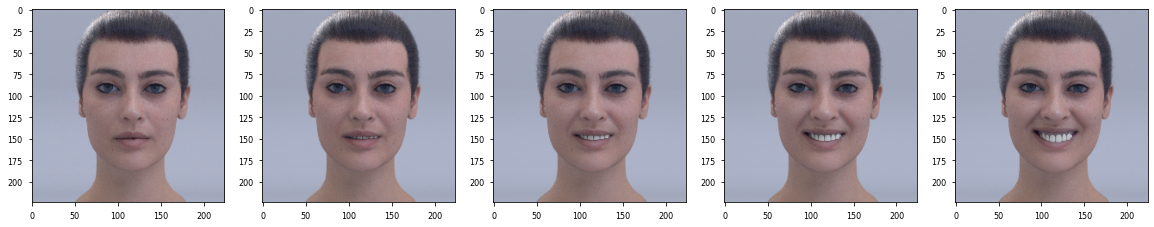

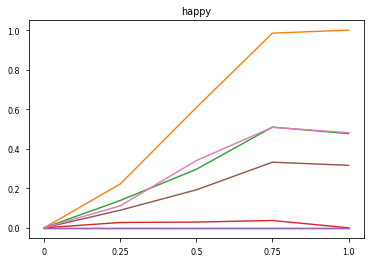

In [66]:
# filter data for happy images
happy_data_x = test_data[0][happy_idx]
happy_data_y = test_data[1][happy_idx]
print("shape happy_data_x", np.shape(happy_data_x))
print("shape happy_data_y", np.shape(happy_data_y))
happy_data = [happy_data_x, happy_data_y]
display_expressivity(happy_data, nr_preds[happy_idx], "happy")

shape angry_data_x (5, 224, 224, 3)
shape angry_data_y (5,)


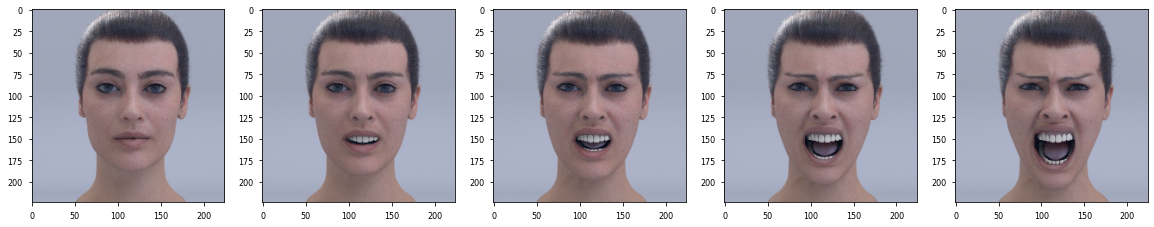

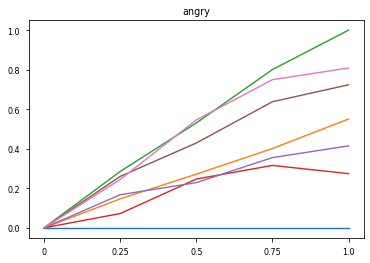

In [67]:
# filter data for happy images
angry_data_x = test_data[0][angry_idx]
angry_data_y = test_data[1][angry_idx]
print("shape angry_data_x", np.shape(angry_data_x))
print("shape angry_data_y", np.shape(angry_data_y))
angry_data = [angry_data_x, angry_data_x]
display_expressivity(angry_data, nr_preds[angry_idx], "angry")

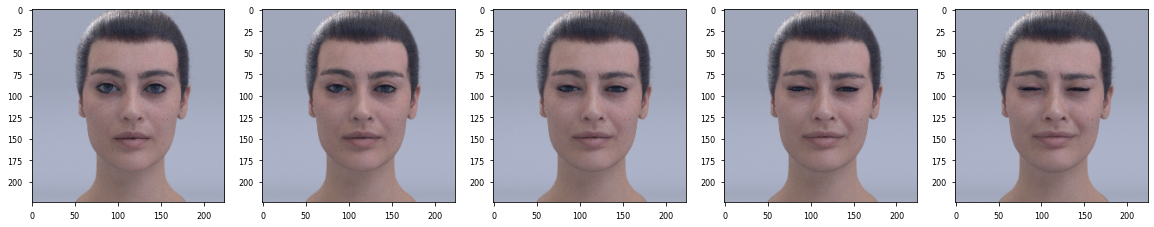

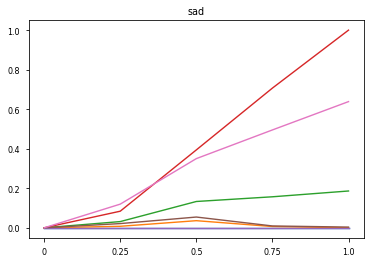

In [68]:
# filter data for happy images
expressive_level_data_x = test_data[0][sad_idx]
expressive_level_data_y = test_data[1][sad_idx]
expressive_level_data = [expressive_level_data_x, expressive_level_data_y]
display_expressivity(expressive_level_data, nr_preds[sad_idx], "sad")

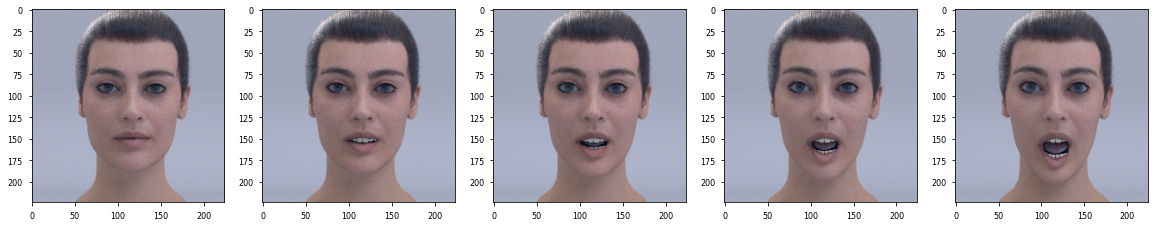

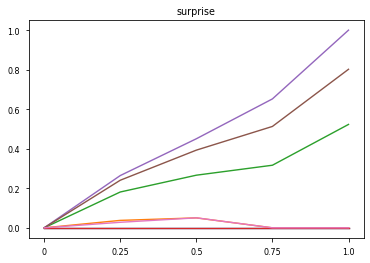

In [69]:
# filter data for happy images
expressive_level_data_x = test_data[0][surprise_idx]
expressive_level_data_y = test_data[1][surprise_idx]
expressive_level_data = [expressive_level_data_x, expressive_level_data_y]
display_expressivity(expressive_level_data, nr_preds[surprise_idx], "surprise")

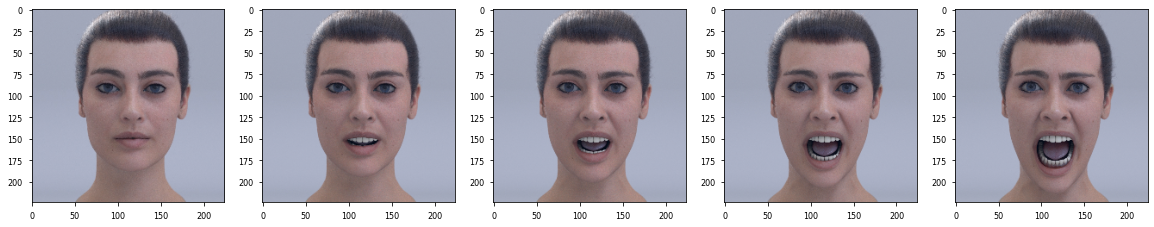

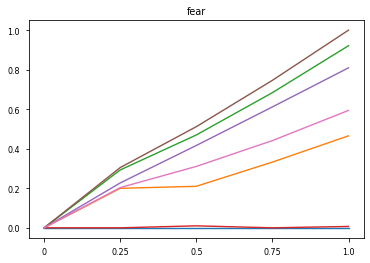

In [70]:
# filter data for happy images
expressive_level_data_x = test_data[0][fear_idx]
expressive_level_data_y = test_data[1][fear_idx]
expressive_level_data = [expressive_level_data_x, expressive_level_data_y]
display_expressivity(expressive_level_data, nr_preds[fear_idx], "fear")

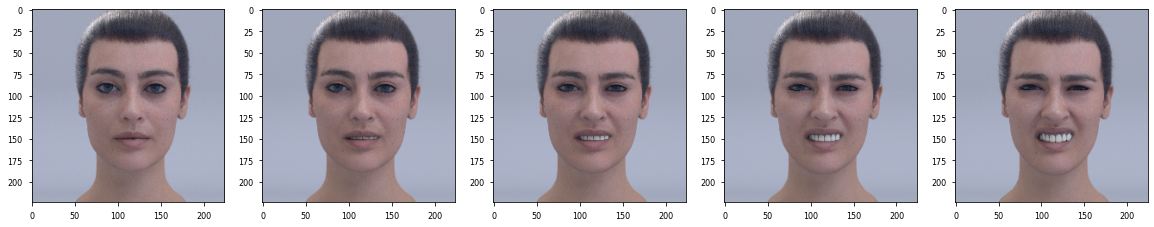

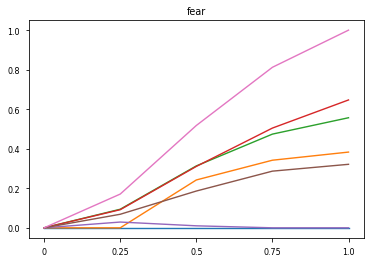

In [71]:
# filter data for happy images
expressive_level_data_x = test_data[0][disgust_idx]
expressive_level_data_y = test_data[1][disgust_idx]
expressive_level_data = [expressive_level_data_x, expressive_level_data_y]
display_expressivity(expressive_level_data, nr_preds[disgust_idx], "disgust")

### Plot all expressivity level

expressivity_level_preds (6, 5)


Text(0, 0.5, 'normed projection length')

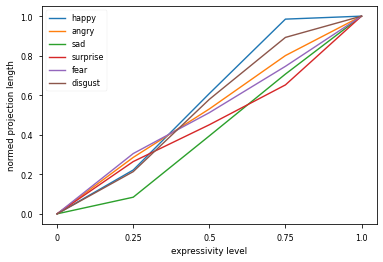

In [89]:
happy_preds = nr_preds[happy_idx, 1]
happy_preds /= np.max(happy_preds)

angry_preds = nr_preds[angry_idx, 2]
angry_preds /= np.max(angry_preds)

sad_preds = nr_preds[sad_idx, 3]
sad_preds /= np.max(sad_preds)

surprise_preds = nr_preds[surprise_idx, 4]
surprise_preds /= np.max(surprise_preds)

fear_preds = nr_preds[fear_idx, 5]
fear_preds /= np.max(fear_preds)

disgust_preds = nr_preds[disgust_idx, 5]
disgust_preds /= np.max(disgust_preds)

expressivity_level_preds = np.vstack([happy_preds, angry_preds, sad_preds, surprise_preds, fear_preds, disgust_preds])
print("expressivity_level_preds", np.shape(expressivity_level_preds))

plt.figure()
plt.plot(expressivity_level_preds.T)
plt.xticks(list(range(len(happy_preds))), [0, 0.25, 0.5, 0.75, 1.0])
plt.legend(["happy", "angry", "sad", "surprise", "fear", "disgust"])
plt.xlabel("expressivity level")
plt.ylabel("normed projection length")